# Training a Custom Entailment Model

In [83]:
import os
import numpy as np
from tqdm import tqdm
from typing import Tuple, Dict, List

import torch
import torch.nn as nn
import torch.optim as optim

from allennlp.predictors.predictor import Predictor
from models.textual_entailment import TextualEntailment
from datasets.arrow_dataset import Dataset


class Entailment:
    
    def __init__(self, load_elmo: bool = True, input_dim: int = 400):
        self.input_dim = 400
        if load_elmo:
            self._frozen = Predictor.from_path("./models/textual_entailment.tar.gz", cuda_device=0)
        self._model = self._model()
        
    def _map(self, label: int) -> str:
        """ Maps the label to the value """
        switcher = {
            0: 'SUPPORTS',
            1: 'NOT ENOUGH INFO',
            2: 'REFUTES'
        }
        return switcher[label]

    def _model(self) -> nn.Sequential:
        """ Builds the MLP for the classification """
        model = nn.Sequential(
          nn.Linear(400,100),
          nn.ReLU(),
          nn.Linear(100,3),
          nn.Softmax(dim=1)
        )
        model.cuda()
        return model
    
    def save(self, path: str = './models/entailment.model') -> None:
        """ Saves the model to the file """
        torch.save(self._model.state_dict(), path)
        
    def load(self, path: str = './models/entailment.model') -> bool:
        """ Loads the model, if possible """
        if os.path.exists(path):
            self._model.load_state_dict(torch.load(path))
            return True
        raise ValueError(f"Path {path} is not valid")

    def entail_dataset(self, dataset: Dataset, batch_size: int = 50, 
                       total_size: int = 30000) -> Tuple[torch.Tensor, torch.Tensor]:
        """ Entails all the data and returns the entailed texts """
        dataset = dataset.shuffle(seed=42)[:total_size]
        X = self.entail_batch(dataset['premise'], dataset['hypothesis'], batch_size)
        y = torch.tensor(dataset['label'])
        return X, y
    
    def entail_batch(self, premises: List[str], hypotheses: List[str], batch_size: int = 50) -> np.ndarray:
        """ Entails all the data and returns the entailed texts """
        batches = [dict(premise=v[0], hypothesis=v[1]) for v in zip(premises, hypotheses)]
        total_size = len(batches)
        
        if total_size < batch_size:
            batch_size = total_size
            
        iters = int(total_size / batch_size)
        X = list()
        
        start = 0
        for j in tqdm(range(iters)):
            end = start + batch_size
            batch_json = self._frozen.predict_batch_json(batches[start:end])
            X.extend([e['aggregate_input'] for e in batch_json])
            start = end
        return torch.tensor(X)
        
    def predict(self, premises: List[str], hypotheses: List[str], batch_size: int = 50) -> torch.Tensor:
        """ Predicts the next word for the text """
        embedding = self.entail_batch(premises, hypotheses)
        embedding = embedding.cuda()
        preds = self._model(embedding)
        return preds
    
    def evaluate(self, X: np.ndarray, y: np.ndarray) -> Tuple[float, float]:
        """ Evaluates the model on the test set """
        n, _ = X.size()
        val = self._model(X)
        preds = torch.argmax(val, dim=1)
        total = float(sum(preds == y)) / n
        return total

    def fit(self, X_train: torch.Tensor, y_train: torch.Tensor, X_val: torch.Tensor, y_val: torch.Tensor, 
            batch_size: int = 32, epochs: int = 100, shuffle: bool = True) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
        """ Fits the data on the model """
        criterion = nn.CrossEntropyLoss()
        optimizer = optim.Adam(self._model.parameters(), lr=1E-3)
        
        X_train = X_train.cuda()
        y_train = y_train.long().cuda()
        X_val = X_val.cuda()
        y_val = y_val.long().cuda()
        
        n, _ = X_train.shape
        tr_iters = int(n / batch_size)
        
        n, _ = X_val.shape
        val_iters = int(n / batch_size)
        
        train_loss = np.zeros(epochs)
        train_acc = np.zeros(epochs)
        validation_loss = np.zeros(epochs)
        validation_acc = np.zeros(epochs)
        for epoch in range(epochs):
            # Train and Validation Loss
            total_loss = self._fit(X_train, y_train, criterion, optimizer, tr_iters, batch_size, shuffle)
            val_loss = self._loss(X_val, y_val, criterion, val_iters, batch_size, shuffle)
            
            total_acc = self.evaluate(X_train, y_train)
            val_acc = self.evaluate(X_val, y_val)
            
            print('[%d] loss: %.7f acc: %.7f \t val_loss: %.7f val_acc: %.7f' % 
                  (epoch + 1, total_loss, total_acc, val_loss, val_acc)
                 )
            
            train_loss[epoch] = total_loss
            train_acc[epoch] = total_acc
            
            validation_loss[epoch] = val_loss
            validation_acc[epoch] = val_acc
        return train_loss, train_acc, validation_loss, validation_acc
    
    def _fit(self, X: torch.Tensor, y: torch.Tensor, criterion: nn.CrossEntropyLoss, 
             optimizer: optim.Adam, num_iters: int, batch_size: int = 32, 
             shuffle: bool = True) -> Tuple[float, float]:
        """ Runs an epoch of training """
        total_loss = 0.0
        if shuffle: 
            indices = np.random.permutation(range(X.shape[0]))
        else:
            indices = list(range(X.shape[0]))

        start = 0
        for i in range(num_iters):
            end = start + batch_size
            i = indices[start:end]
            xi, yi = X[i], y[i]

            # zero the parameter gradients
            optimizer.zero_grad()

            # forward + backward + optimize
            outputs = self._model(xi)
            loss = criterion(outputs, yi)
            loss.backward()
            optimizer.step()

            total_loss += loss.item()
            start = end

        total_loss /= X.shape[0]
        return total_loss
    
    def _loss(self, X: torch.Tensor, y: torch.Tensor, criterion: nn.CrossEntropyLoss, 
              num_iters: int, batch_size: int = 32, shuffle: bool = True) -> Tuple[float, float]:
        """ Runs an epoch of training """
        total_loss = 0.0

        if shuffle: 
            indices = np.random.permutation(range(X.shape[0]))
        else:
            indices = list(range(X.shape[0]))

        start = 0
        for i in range(num_iters):
            end = start + batch_size
            i = indices[start:end]
            xi, yi = X[i], y[i]

            # forward + loss
            outputs = self._model(xi)
            loss = criterion(outputs, yi)
            total_loss += loss.item()
            start = end
        total_loss /= X.shape[0]
        return total_loss


**Warning**: Do not run the below code unless you want to regenerate the entailments. **THIS TAKES A LONG TIME TO DO**

```
from datasets import load_dataset
from datasets.arrow_dataset import Dataset

snli_data = load_dataset('snli')
```

```
snli_data['train'].shape, snli_data['validation'].shape, snli_data['test'].shape
```

```
entailment = Entailment()
```

```
def get_balanced_data(entailment: Entailment, data: Dataset) -> Tuple[np.ndarray, np.ndarray]:
    """ Gets the training data for the entailment model """
    entailments = data.filter(lambda x: x['label'] == 0)
    neutrals = data.filter(lambda x: x['label'] == 1)
    contradictions = data.filter(lambda x: x['label'] == 2)
    X_entail, y_entail = entailment.entail_dataset(entailments, batch_size=100, total_size=100000)
    X_neutral, y_neutral = entailment.entail_dataset(neutrals, batch_size=100, total_size=100000)
    X_contra, y_contra = entailment.entail_dataset(contradictions, batch_size=100, total_size=100000)
    X_train = torch.vstack((X_entail, X_neutral))
    X_train = torch.vstack((X_train, X_contra))
    y_train = torch.hstack((y_entail, y_neutral))
    y_train = torch.hstack((y_train, y_contra))
    return X_train, y_train

X_train, y_train = get_balanced_data(entailment, snli_data['train'])
X_train.shape, y_train.shape
```

```
sum(y_train == 0), sum(y_train == 1), sum(y_train == 2)
```

```
x_train_path = './data/x_train.pt'
torch.save(X_train, x_train_path)

y_train_path = './data/y_train.pt'
torch.save(y_train, y_train_path)
```

```
total_val = snli_data['validation'].shape[0]
X_val, y_val = entailment.entail_dataset(snli_data['validation'], batch_size=100, total_size=total_val)
X_val.shape, y_val.shape
```

```
x_val_path = './data/x_validation.pt'
torch.save(X_val, x_val_path)

y_val_path = './data/y_validation.pt'
torch.save(y_val, y_val_path)
```

```
total_test = snli_data['test'].shape[0]
X_test, y_test = entailment.entail_dataset(snli_data['test'], batch_size=100, total_size=total_test)
X_test.shape, y_test.shape
```

```
x_test_path = './data/x_test.pt'
torch.save(X_test, x_test_path)

y_test_path = './data/y_test.pt'
torch.save(y_test, y_test_path)
```

In [2]:
def load_arrays(x_path: str, y_path: str) -> Tuple[torch.Tensor, torch.Tensor]:
    X = torch.load(x_path)
    y = torch.load(y_path)
    return X, y

In [3]:
x_train_path = './data/x_train.pt'
y_train_path = './data/y_train.pt'

X_train, y_train = load_arrays(x_train_path, y_train_path)
X_train.shape, y_train.shape

(torch.Size([300000, 400]), torch.Size([300000]))

In [4]:
sum(y_train == 0), sum(y_train == 1), sum(y_train == 2)

(tensor(100000), tensor(100000), tensor(100000))

In [5]:
x_val_path = './data/x_validation.pt'
y_val_path = './data/y_validation.pt'

X_val, y_val = load_arrays(x_val_path, y_val_path)

pos = torch.nonzero(y_val != -1)  # Remove -1
pos = pos.reshape(pos.size()[0])  # Remove -1

X_val = X_val[pos]
y_val = y_val[pos]

X_val.shape, y_val.shape

(torch.Size([9842, 400]), torch.Size([9842]))

In [6]:
sum(y_val == 0), sum(y_val == 1)

(tensor(3329), tensor(3235))

In [7]:
x_test_path = './data/x_test.pt'
y_test_path = './data/y_test.pt'

X_test, y_test = load_arrays(x_test_path, y_test_path)

pos = torch.nonzero(y_test != -1)  # Remove -1
pos = pos.reshape(pos.size()[0])  # Remove -1

X_test = X_test[pos]
y_test = y_test[pos]

X_test.shape, y_test.shape

(torch.Size([9824, 400]), torch.Size([9824]))

In [8]:
sum(y_test == 0), sum(y_test == 1)

(tensor(3368), tensor(3219))

In [9]:
entailment = Entailment(False)

In [10]:
loss, acc, val_loss, val_acc = entailment.fit(X_train, y_train, X_val, y_val, epochs=10)

[1] loss: 0.0205580 acc: 0.8926800 	 val_loss: 0.0215004 val_acc: 0.8585653
[2] loss: 0.0203489 acc: 0.9008433 	 val_loss: 0.0213094 val_acc: 0.8663889
[3] loss: 0.0202893 acc: 0.9038533 	 val_loss: 0.0212813 val_acc: 0.8653729
[4] loss: 0.0202557 acc: 0.9017500 	 val_loss: 0.0213416 val_acc: 0.8642552
[5] loss: 0.0202150 acc: 0.9056867 	 val_loss: 0.0212463 val_acc: 0.8672018
[6] loss: 0.0201876 acc: 0.9050367 	 val_loss: 0.0213716 val_acc: 0.8627312
[7] loss: 0.0201700 acc: 0.9064367 	 val_loss: 0.0212367 val_acc: 0.8686243
[8] loss: 0.0201386 acc: 0.9074167 	 val_loss: 0.0212640 val_acc: 0.8672018
[9] loss: 0.0201345 acc: 0.9068500 	 val_loss: 0.0212183 val_acc: 0.8687259
[10] loss: 0.0201165 acc: 0.9089167 	 val_loss: 0.0213008 val_acc: 0.8651697


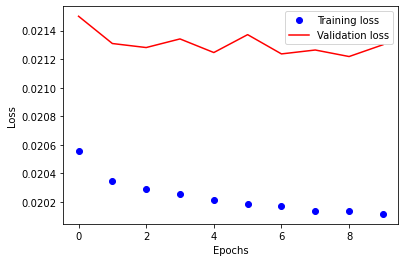

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline

epochs = list(range(10))

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

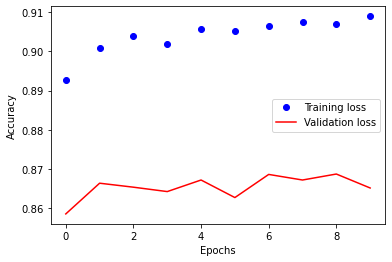

In [13]:
plt.plot(epochs, acc, 'bo', label='Training loss')
plt.plot(epochs, val_acc, 'r', label='Validation loss')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [14]:
entailment.save()

In [15]:
entailment.evaluate(X_test.cuda(), y_test.long().cuda())

0.8560667752442996

In [16]:
model = Entailment(False)
model.load()
model.evaluate(X_test.cuda(), y_test.long().cuda())

0.8560667752442996

# Loading the FEVER Dataset & Entailment Model

In [1]:
from datasets import load_dataset

dataset = load_dataset('fever', 'v1.0')
data = dataset['paper_test']
data.shape

Reusing dataset fever (/home/jmack/.cache/huggingface/datasets/fever/v1.0/1.0.0/fe391c4f48669454ae0d368997430e6fa476aacb476d930d3328b67356e74625)


(18567, 7)

**Remark**: You can use the above model or this model, the results are very similar

In [2]:
from allennlp.predictors.predictor import Predictor

entailment_model = Predictor.from_path("./models/decomposable-attention-elmo-2020.04.09.tar.gz", cuda_device=0)

/home/jmack/anaconda3/envs/final-project/lib/python3.8/site-packages/torch/nn/modules/container.py:435: UserWarning: Setting attributes on ParameterList is not supported.
  warnings.warn("Setting attributes on ParameterList is not supported.")


# The Facebook Experiment

1. Implement automatic masking
2. Get the top 1 prediction from the LM 
3. Fill in the mask
4. Use the claim and filled in sentence and input into an entailment model
5. Input entailment into MLP for final fact-verification prediction

In [3]:
from operator import itemgetter
from typing import Iterable, List, Tuple
from sklearn.metrics import precision_recall_fscore_support, accuracy_score

import os
import spacy
import numpy as np
from tqdm import tqdm
from typing import Optional, Tuple, Dict, List

import torch
import torch.nn as nn
import torch.optim as optim

from datasets.arrow_dataset import Dataset


class Pipeline:
    
    def __init__(self, tokenizer, unmasker, model):
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.nlp = spacy.load("en_core_web_sm")
        self.mask_token = tokenizer.mask_token
        self.tokenizer = tokenizer
        self.unmasker = unmasker.to(self.device)
        self.model = model
        self.vocab = tokenizer.get_vocab()
        
    def __call__(self, dataset: Dataset = None, limit: int = 0, save: bool = False, load: bool = False,
                 path: str = None) -> Tuple[np.ndarray, np.ndarray]:
        """ Performs all operations on the dataset """
        if (save or load) and not path:
            raise ValueError("Must pass a path to save the processed dataset")
        
        if load:
            dataset = self.load(path)
            return self.evaluate_dataset(dataset)
        
        print("Masking the claims and filling the masks for the dataset")
        data = self.mask_and_fill(dataset, limit)
        if save:
            print("Saving checkpoint...")
            data.to_csv(path)
        return self.evaluate_dataset(data)
    
    def load(self, path: str) -> Dataset:
        """ Loads the dataset from a file """
        if os.path.exists(path) and os.path.isfile(path):
            return load_dataset('csv', data_files=[path])['train']
        raise ValueError(f"Path {path} does not exist or is not a file")
        
    def mask_and_fill(self, dataset: Dataset, limit: int = 0) -> Dataset:
        """ Masks the entire dataset """            
        if limit != 0:
            dataset = dataset.select(list(range(limit)))
        data = dataset.map(self._mask)
        data = data.filter(lambda x: x['masked'] is not None)
        data = data.map(self._fill)
        return data
    
    def _mask(self, x: dict) -> dict:
        """ Masks the last named entity in the string """
        x['target'] = None
        x['masked'] = None
        x['label'] = self._map(x['label'])
        claim = x['claim']
        doc = self.nlp(claim, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])
        ents = doc.ents
        if ents:
            target = self._get_target(ents)
            if target:  # If the target is not in the vocab, skip the entry
                masked = self.mask_token.join(claim.rsplit(target, 1))
                x['target'] = target
                x['masked'] = masked
        return x
    
    def _get_target(self, ents) -> Optional[str]:
        """ Gets the ideal target """
        for i in reversed(range(len(ents))):
            words = ents[i].text.split()
            for word in words:
                if self.vocab.get(word):
                    return word
        return None
            
    def _fill(self, x: dict) -> dict:
        """ Fills the masked token with the  top-1 predicted value """
        x['pred'] = self._predict(x['masked'])
        x['hypothesis'] = x['masked'].replace(self.mask_token, x['pred'])
        return x
    
    def _predict(self, masked_claim: str) -> str:
        """ Fills the masked token with the  top-1 predicted value """
        tokens = self.tokenizer(masked_claim, return_tensors='pt')
        masked_index = torch.nonzero(tokens['input_ids'][0] == self.tokenizer.mask_token_id, as_tuple=False)
        # Fill mask pipeline supports only one ${mask_token} per sample
        num = np.prod(masked_index.shape)
        if num > 1 or num < 1:
            print(masked_claim, tokens, masked_index)
            raise ValueError(f"Pipeline only supports one masked index: {num} is not supported")

        outputs = self.unmasker(**tokens.to(self.device))
        logits = outputs.logits[0, masked_index.item(), :]
        probs = logits.softmax(dim=0)
        values, predictions = probs.topk(1)
        word = self.tokenizer.decode(predictions)
        return word.strip()
    
    def predict_batch(self, premises: List[str], hypotheses: List[str], batch_size: int = 50) -> np.ndarray:
        """ Entails all the data and returns the entailed texts """
        batches = [dict(premise=v[0], hypothesis=v[1]) for v in zip(premises, hypotheses)]
        total_size = len(batches)
        
        if total_size < batch_size:
            batch_size = total_size
            iters = 1
        else:
            iters = int(total_size / batch_size) + 1
            
        X = list()
        
        start = 0
        for j in tqdm(range(iters)):
            end = start + batch_size
            if end >= total_size:
                end = total_size
            batch_json = self.model.predict_batch_json(batches[start:end])
            X.extend([e['label_probs'] for e in batch_json])
            start = end
        return torch.tensor(X)
    
    def evaluate_dataset(self, dataset: Dataset) -> Tuple[np.ndarray, np.ndarray]:
        """ Evaluates how well the model is able to predict """
        premise, hypothesis = dataset['claim'], dataset['hypothesis']
        y_pred = torch.argmax(self.predict_batch(premise, hypothesis), dim=1)
        y_true = np.array(dataset['label'])
        return y_true, y_pred.numpy()
    
    def evaluate(self, y_true: List[int], y_pred: List[int]) -> tuple:
        """ Evaluates how well the model is able to predict """
        metrics = precision_recall_fscore_support(y_true, y_pred)
        macro = precision_recall_fscore_support(y_true, y_pred, average='macro')
        acc = accuracy_score(y_true, y_pred)
        return metrics, macro, acc
    
    def _map(self, label: int) -> str:
        """ Maps the label to the value """
        switcher = {
            'SUPPORTS': 0,
            'NOT ENOUGH INFO': 1,
            'REFUTES': 2
        }
        return switcher[label]

In [4]:
from transformers import BertTokenizerFast, BertForMaskedLM

bert_tokenizer = BertTokenizerFast.from_pretrained('bert-large-cased-whole-word-masking')
bert_model = BertForMaskedLM.from_pretrained('bert-large-cased-whole-word-masking')

Some weights of the model checkpoint at bert-large-cased-whole-word-masking were not used when initializing BertForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
pipe = Pipeline(bert_tokenizer, bert_model, entailment_model)

**Remark**: Only needs to be run once, otherwise you can load the data directly using the second command

In [8]:
bert_y_true, bert_y_pred = pipe(data, save=True, path='./data/bert_paper_test.csv') # Process

Masking the claims and filling the masks for the dataset



Saving checkpoint...


  0%|          | 0/174 [00:00<?, ?it/s]

100%|██████████| 174/174 [00:44<00:00,  3.88it/s]


In [6]:
bert_y_true, bert_y_pred = pipe(data, load=True, path='./data/bert_paper_test.csv') # Load & Process

Using custom data configuration default-025ce9815ef0181d
Reusing dataset csv (/home/jmack/.cache/huggingface/datasets/csv/default-025ce9815ef0181d/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)
100%|██████████| 285/285 [01:12<00:00,  3.93it/s]


In [7]:
bert_metrics, bert_macro, bert_acc = pipe.evaluate(bert_y_true, bert_y_pred)
bert_metrics, bert_macro, bert_acc

((array([0.40040702, 0.24450704, 0.46094946]),
  array([0.85714286, 0.12667834, 0.05694287]),
  array([0.54583285, 0.16689098, 0.10136387]),
  array([5509, 3426, 5286])),
 (0.36862117579333087, 0.3469213557286139, 0.27136256672250425, None),
 0.3837282891498488)

# Broad Check on Models

### BART

- Unknown training dataset

In [8]:
from transformers import BartTokenizerFast, BartForConditionalGeneration

bart_tokenizer = BartTokenizerFast.from_pretrained("facebook/bart-large")
bart_model = BartForConditionalGeneration.from_pretrained("facebook/bart-large")

In [9]:
pipe = Pipeline(bart_tokenizer, bart_model, entailment_model)

In [12]:
bart_y_true, bart_y_pred = pipe(data, save=True, path='./data/bart_paper_test.csv') # Process

Masking the claims and filling the masks for the dataset



Saving checkpoint...


  0%|          | 0/165 [00:00<?, ?it/s]

100%|██████████| 165/165 [00:42<00:00,  3.88it/s]


In [10]:
bart_y_true, bart_y_pred = pipe(data, load=True, path='./data/bart_paper_test.csv') # Load & Process

Using custom data configuration default-603c3cb2a5daf17b
Reusing dataset csv (/home/jmack/.cache/huggingface/datasets/csv/default-603c3cb2a5daf17b/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)
100%|██████████| 232/232 [01:00<00:00,  3.83it/s]


In [12]:
bart_freeze_metrics, bart_freeze_macro, bart_freeze_acc = pipe.evaluate(bart_y_true, bart_y_pred)
bart_freeze_metrics, bart_freeze_macro, bart_freeze_acc

((array([0.39114821, 0.19481982, 0.4       ]),
  array([0.91259058, 0.06169757, 0.03409353]),
  array([0.54759155, 0.09371614, 0.06283167]),
  array([4416, 2804, 4341])),
 (0.3286560096930863, 0.3361272271467631, 0.23471312063635574, None),
 0.37635152668454286)

### RoBERTa

- Trained on Bookcorpus, Wikipedia and CC News datasets

In [13]:
from transformers import BigBirdTokenizer, BigBirdForMaskedLM
  
bigbird_tokenizer = BigBirdTokenizer.from_pretrained("google/bigbird-roberta-large")
bigbird_model = BigBirdForMaskedLM.from_pretrained("google/bigbird-roberta-large")

Some weights of the model checkpoint at google/bigbird-roberta-large were not used when initializing BigBirdForMaskedLM: ['cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BigBirdForMaskedLM from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BigBirdForMaskedLM from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [14]:
pipe = Pipeline(bigbird_tokenizer, bigbird_model, entailment_model)

In [21]:
bigbird_y_true, bigbird_y_pred = pipe(data, save=True, path='./data/bigbird_paper_test.csv') # Process

Masking the claims and filling the masks for the dataset


Attention type 'block_sparse' is not possible if sequence_length: 14 <= num global tokens: 2 * config.block_size + min. num sliding tokens: 3 * config.block_size + config.num_random_blocks * config.block_size + additional buffer: config.num_random_blocks * config.block_size = 704 with config.block_size = 64, config.num_random_blocks = 3.Changing attention type to 'original_full'...



Saving checkpoint...


  0%|          | 0/212 [00:00<?, ?it/s]

100%|██████████| 212/212 [00:54<00:00,  3.90it/s]


In [15]:
bigbird_y_true, bigbird_y_pred = pipe(data, load=True, path='./data/bigbird_paper_test.csv') # Load & Process

Using custom data configuration default-c87a382d2406e7ce
Reusing dataset csv (/home/jmack/.cache/huggingface/datasets/csv/default-c87a382d2406e7ce/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)
100%|██████████| 232/232 [01:00<00:00,  3.81it/s]


In [16]:
bb_metrics, bb_macro, bb_acc = pipe.evaluate(bigbird_y_true, bigbird_y_pred)
bb_metrics, bb_macro, bb_acc

((array([0.39213263, 0.21348315, 0.38491049]),
  array([0.86231884, 0.08131241, 0.06933886]),
  array([0.53910951, 0.1177686 , 0.11750927]),
  array([4416, 2804, 4341])),
 (0.330175421699136, 0.337656704478242, 0.25812912452361464, None),
 0.3751405587751925)

## ALBERT v2

- Model was trained on Bookcorpus and Wikipedia

In [17]:
from transformers import AlbertTokenizerFast, AlbertForMaskedLM
  
albert_tokenizer = AlbertTokenizerFast.from_pretrained("albert-large-v2")
albert_model = AlbertForMaskedLM.from_pretrained("albert-large-v2")

In [18]:
pipe = Pipeline(albert_tokenizer, albert_model, entailment_model)

In [ ]:
albert_y_true, albert_y_pred = pipe(data, save=True, path='./data/albert_paper_test.csv')

In [19]:
albert_y_true, albert_y_pred = pipe(data, load=True, path='./data/albert_paper_test.csv')  # Load & Process

Using custom data configuration default-8e7b121b58b205f1
Reusing dataset csv (/home/jmack/.cache/huggingface/datasets/csv/default-8e7b121b58b205f1/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)
100%|██████████| 102/102 [00:27<00:00,  3.69it/s]


In [20]:
albert_metrics, albert_macro, albert_acc = pipe.evaluate(albert_y_true, albert_y_pred)
albert_metrics, albert_macro, albert_acc

((array([0.3572282 , 0.20067454, 0.49044586]),
  array([0.85379783, 0.0958132 , 0.07336827]),
  array([0.5037062 , 0.12970027, 0.12764194]),
  array([1751, 1242, 2099])),
 (0.34944953068893625, 0.34099310164181434, 0.2536828038116286, None),
 0.3472113118617439)

# Inserting a Context Layer into the Pipeline

- We will try using the autoregressive language model GPT2

### Fine Tuning GPT2 on CC News Dataset

1. Open up a terminal, navigate to `/path/to/project/finetuning/` and run `run_clm.sh`
2. Wait until it finishes
3. **Note**: This only trains GPT2 on 150,000 samples of the CC News dataset. Please adjust the script to suit both your GPU settings and your fine-tuning needs
4. I plan to upload the model fine-tuned on the complete dataset at a later date

### Fine Tuning BART on FEVER

1. Open up a terminal, navigate to `/path/to/project/finetuning/` and run `run_mlm.sh`
2. Wait until it finishes
3. **Note**: This only trains BART on 150,000 samples of the FEVER dataset. Please adjust the script to suit both your GPU settings and your fine-tuning needs
4. I plan to upload the model fine-tuned on the complete dataset at a later date

### Adjusting the Pipeline - Adding Generation

In [21]:
from transformers.generation_utils import logger
import logging


class PipelineWithContext(Pipeline):
    
    def __init__(self, tokenizer, unmasker, text_generator, model):
        super().__init__(tokenizer, unmasker, model)
        self.text_generator = text_generator
        self.max_len = tokenizer.model_max_length
        logger.setLevel(logging.ERROR)
    
    def __call__(self, dataset: Dataset = None, limit: int = 0, mask: bool = False, context: bool = False,
                 fill: bool = False, save: bool = False, load: bool = False, 
                 path: str = None) -> Tuple[np.ndarray, np.ndarray]:
        """ Performs all operations on the dataset """
        if (save or load) and not path:
            raise ValueError("Must pass a path to save the processed dataset")
        
        if load:
            dataset = self.load(path)
        
        if dataset and not load:
            context = True
            fill = True
        
        if limit != 0:
            dataset = dataset.select(list(range(limit)))
        
        if mask:
            print("Masking the claims...")
            dataset = dataset.map(self._mask)
            dataset = dataset.filter(lambda x: x['target'] != None)
        
        if context:
            print("Adding context to the dataset")
            dataset = self.add_context(dataset)
            if save:
                print("Saving checkpoint...")
                dataset.to_csv(path)
        if fill:
            print("Filling the context masks")
            dataset = self.fill_context(dataset)
            if save:
                print("Saving checkpoint...")
                dataset.to_csv(path)
        return self.evaluate_dataset(dataset)
        
    def add_context(self, dataset: Dataset, limit: int = 0) -> Dataset:
        """ Masks the entire dataset """            
        if limit != 0:
            dataset = dataset.select(list(range(limit)))
        data = dataset.map(self._contextualize)
        return data
    
    def _contextualize(self, x: dict) -> str:
        """ Generates context for the claim """
        context = self.text_generator(x['claim'], max_length=50, do_sample=False)[0]['generated_text']
        if len(context) > self.max_len:
            context = context[:self.max_len]
        x['context'] = context.replace('\n', ' ')  # Remove newlines to avoid error in Entailment model
        return x
    
    def fill_context(self, dataset: Dataset, limit: int = 0) -> Dataset:
        """ Fills the context map """
        if limit != 0:
            dataset = dataset.select(list(range(limit)))
        data = dataset.map(self._fill)
        return data
    
    def _fill(self, x: dict) -> dict:
        """ Masks the claim and fills the mask """
        x['masked_context'] = x['masked'].join(x['context'].split(x['claim'], 1))
        x['context_pred'] = self._predict(x['masked_context'])
        x['context_hypothesis'] = x['masked_context'].replace(self.mask_token, x['context_pred'])
        x['filled'] = x['masked'].replace(self.mask_token, x['context_pred'])
        return x
        
    def evaluate_dataset(self, dataset: Dataset) -> Tuple[np.ndarray, np.ndarray]:
        """ Evaluates how well the model is able to predict """
        premise, hypothesis = dataset['context'], dataset['context_hypothesis']
        y_pred = torch.argmax(self.predict_batch(premise, hypothesis), dim=1)
        y_true = np.array(dataset['label'])
        return y_true, y_pred.numpy()
    
    def _map(self, label: int) -> str:
        """ Maps the label to the value """
        switcher = {
            'SUPPORTS': 0,
            'NOT ENOUGH INFO': 1,
            'REFUTES': 2
        }
        return switcher[label]

In [22]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel
from transformers import pipeline

gpt2_dir = '/run/media/jmack/ColdStorage/models/gpt2'
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_dir)
gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_dir)

text_generator = pipeline("text-generation", model=gpt2_model, tokenizer=gpt2_tokenizer, device=0)

In [23]:
from transformers import BartTokenizer, BartForConditionalGeneration

bart_dir = '/run/media/jmack/ColdStorage/models/bart_large'
bart_tokenizer = BartTokenizer.from_pretrained(bart_dir)
bart_model = BartForConditionalGeneration.from_pretrained(bart_dir)

### A Toy Example with Finetuned Models

In [24]:
text = "Thomas Jefferson founded the University of Virginia."
masked_text = "Thomas Jefferson founded the University of <mask>."
context = text_generator("Thomas Jefferson founded the University of Virginia.", max_length=75, do_sample=False)
context

Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


[{'generated_text': 'Thomas Jefferson founded the University of Virginia. He was born in Richmond, Virginia, on July 4, 1847. He graduated from the University of Virginia in 1871. He was a member of the Virginia Board of Trustees from 1871 to 1873. He was a member of the Virginia State Board of Education from 1873 to 1874. He was a member of'}]

In [25]:
context = f"{'.'.join(context[0]['generated_text'].split('.')[:-1])}."
masked_context = context.replace(text, masked_text)
masked_context

'Thomas Jefferson founded the University of <mask>. He was born in Richmond, Virginia, on July 4, 1847. He graduated from the University of Virginia in 1871. He was a member of the Virginia Board of Trustees from 1871 to 1873. He was a member of the Virginia State Board of Education from 1873 to 1874.'

In [26]:
def predict(tokenizer, model, masked_claim: str) -> str:
    """ Fills the masked token with the  top-1 predicted value """
    tokens = tokenizer(masked_claim, return_tensors='pt')
    masked_index = torch.nonzero(tokens['input_ids'][0] == tokenizer.mask_token_id, as_tuple=False)
    # Fill mask pipeline supports only one ${mask_token} per sample
    num = np.prod(masked_index.shape)
    if num > 1 or num < 1:
        print(masked_claim, tokens, masked_index)
        raise ValueError(f"Pipeline only supports one masked index: {num} is not supported")

    outputs = model(**tokens)
    logits = outputs.logits[0, masked_index.item(), :]
    probs = logits.softmax(dim=0)
    values, predictions = probs.topk(1)
    word = tokenizer.decode(predictions)
    return word.strip()

predict(bart_tokenizer, bart_model, masked_context)

'Virginia'

### Running the Pipeline

In [27]:
pipe = PipelineWithContext(bart_tokenizer, bart_model, text_generator, entailment_model)

In [ ]:
bart_y_true, bart_y_pred = pipe(data, mask=True, save=True, path='./data/bart_context_paper_test.csv') # Process

In [28]:
bart_y_true, bart_y_pred = pipe(data, load=True, path='./data/bart_context_paper_test.csv') # Load

Using custom data configuration default-2e0d9d57f64d77ff
Reusing dataset csv (/home/jmack/.cache/huggingface/datasets/csv/default-2e0d9d57f64d77ff/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)
100%|██████████| 232/232 [01:54<00:00,  2.02it/s]


In [51]:
bart_context_metrics, bart_context_macro, bart_context_acc = pipe.evaluate(bart_y_true, bart_y_pred)
bart_context_metrics, bart_context_macro, bart_context_acc

((array([0.39515043, 0.22238267, 0.36750789]),
  array([0.79710145, 0.10984308, 0.10734854]),
  array([0.52836986, 0.1470518 , 0.16616153]),
  array([4416, 2804, 4341])),
 (0.3283469948327742, 0.3380976892637275, 0.28052772911980967, None),
 0.3714211573393305)

# Question and Answer Pipeline

- The first pipeline uses a "Closed Book Approach" proposed by Google.
- The second pipeline uses an "Open Book Approach" using the finetuned GPT2 generator.

In [30]:

class QAPipeline:
    
    def __init__(self, question_tokenizer, question_generator, answer_tokenizer, answer_generator, 
                 entailment_model, mask_token: str = '[MASK]'):
        self.device = "cuda:0" if torch.cuda.is_available() else "cpu"
        self.nlp = spacy.load("en_core_web_sm")
        self.mask_token = mask_token
        self.model = entailment_model
        self.question_tokenizer = question_tokenizer
        self.answer_tokenizer = answer_tokenizer
        self.vocab = answer_tokenizer.get_vocab()
        self.max_len = min(question_tokenizer.model_max_length, answer_tokenizer.model_max_length)
        
        try:
            self.question_generator = question_generator.to(self.device)
        except:
            self.question_generator = question_generator
        
        try:
            self.answer_generator = answer_generator.to(self.device)
        except:
            self.answer_generator = answer_generator
            
    def __call__(self, dataset: Dataset = None, limit: int = 0, mask: bool = False, questionize: bool = False,
                 answer: bool = False, save: bool = False, load: bool = False, 
                 path: str = None) -> Tuple[Dataset, Tuple[np.ndarray, np.ndarray]]:
        """ Performs all operations on the dataset """
        if (save or load) and not path:
            raise ValueError("Must pass a path to save the processed dataset")
        
        if load:
            dataset = self.load(path)
        
        if dataset and not load:
            mask = questionize = answer = True
        
        if limit != 0:
            dataset = dataset.select(list(range(limit)))
        
        if mask:
            print("Masking the claims and retrieving answers")
            dataset = dataset.map(self._mask)
            dataset = dataset.filter(lambda x: x['answer'] != None)
        
        if questionize:
            print("Generating questions from the claims")
            dataset = self.generate_questions(dataset)
            if save:
                print("Saving checkpoint...")
                dataset.to_csv(path)
 
        if answer:
            print("Answering the questions")
            dataset = self.generate_answers(dataset)
            if save:
                print("Saving checkpoint...")
                dataset.to_csv(path)
        return dataset, self.evaluate_dataset(dataset)
    
    def load(self, path: str) -> Dataset:
        """ Loads the dataset from a file """
        if os.path.exists(path) and os.path.isfile(path):
            return load_dataset('csv', data_files=[path])['train']
        raise ValueError(f"Path {path} does not exist or is not a file")
    
    def _mask(self, x: dict) -> dict:
        """ Masks the last named entity in the string """
        x['answer'] = None
        x['masked'] = None
        x['label'] = self._map(x['label'])
        claim = x['claim']
        doc = self.nlp(claim, disable=["tok2vec", "tagger", "parser", "attribute_ruler", "lemmatizer"])
        ents = doc.ents
        if ents:
            answer = self._get_target(ents)
            masked = self.mask_token.join(claim.rsplit(answer, 1))
            x['answer'] = answer
            x['masked'] = masked
        return x
    
    def _get_target(self, ents) -> Optional[str]:
        """ Gets the ideal target """
        for i in reversed(range(len(ents))):
            words = ents[i].text.split()
            for word in words:
                if self.vocab.get(word):
                    return word
        return None
        
    def generate_questions(self, dataset: Dataset, limit: int = 0) -> Dataset:
        """ Masks the entire dataset """            
        if limit != 0:
            dataset = dataset.select(list(range(limit)))
        data = dataset.map(self._questionize)
        return data
    
    def _questionize(self, x: dict) -> dict:
        """ Masks the claim and fills the mask """
        input_text = f"answer: {x['answer']} context: {x['claim']} </s>"
        features = self.question_tokenizer([input_text], return_tensors='pt').to(self.device)
        output = self.question_generator.generate(input_ids=features['input_ids'], 
                                                  attention_mask=features['attention_mask'],
                                                  max_length=self.max_len)

        question = self.question_tokenizer.decode(output[0], skip_special_tokens=True)
        x['question'] = question.replace('question: ', '')
        return x
    
    def generate_answers(self, dataset: Dataset, limit: int = 0) -> Dataset:
        """ Masks the entire dataset """            
        if limit != 0:
            dataset = dataset.select(list(range(limit)))
        data = dataset.map(self._answer_question)
        return data
   
    def _answer_question(self, x: dict) -> str:
        """ Answers the question and fills the masked claim """
        input_ids = self.answer_tokenizer(x['question'], return_tensors="pt").input_ids
        pred_answer = self.answer_generator.generate(input_ids.to(self.device))[0]
        response = self.answer_tokenizer.decode(pred_answer, skip_special_tokens=True)
        x['pred'] = response
        x['hypothesis'] = x['masked'].replace(self.mask_token, response)
        return x
    
    def predict_batch(self, premises: List[str], hypotheses: List[str], batch_size: int = 50) -> np.ndarray:
        """ Entails all the data and returns the entailed texts """
        batches = [dict(premise=v[0], hypothesis=v[1]) for v in zip(premises, hypotheses)]
        total_size = len(batches)
        
        if total_size < batch_size:
            batch_size = total_size
            iters = 1
        else:
            iters = int(total_size / batch_size) + 1
            
        X = list()
        
        start = 0
        for j in tqdm(range(iters)):
            end = start + batch_size
            if end >= total_size:
                end = total_size
            batch_json = self.model.predict_batch_json(batches[start:end])
            X.extend([e['label_probs'] for e in batch_json])
            start = end
        return torch.tensor(X)
    
    def evaluate_dataset(self, dataset: Dataset) -> Tuple[np.ndarray, np.ndarray]:
        """ Evaluates how well the model is able to predict """
        premise, hypothesis = dataset['claim'], dataset['hypothesis']
        y_pred = torch.argmax(self.predict_batch(premise, hypothesis), dim=1)
        y_true = np.array(dataset['label'])
        return y_true, y_pred.numpy()
    
    def evaluate(self, y_true: List[int], y_pred: List[int]) -> tuple:
        """ Evaluates how well the model is able to predict """
        metrics = precision_recall_fscore_support(y_true, y_pred)
        macro = precision_recall_fscore_support(y_true, y_pred, average='macro')
        acc = accuracy_score(y_true, y_pred)
        return metrics, macro, acc
    
    def _map(self, label: int) -> str:
        """ Maps the label to the value """
        switcher = {
            'SUPPORTS': 0,
            'NOT ENOUGH INFO': 1,
            'REFUTES': 2
        }
        return switcher[label]

In [31]:
from transformers import AutoModelForSeq2SeqLM, AutoTokenizer

question_tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-question-generation-ap")
question_model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-base-finetuned-question-generation-ap")

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [32]:
answer_tokenizer = AutoTokenizer.from_pretrained("google/t5-small-ssm-nq")
answer_model = AutoModelForSeq2SeqLM.from_pretrained("google/t5-small-ssm-nq")

In [33]:
pipe = QAPipeline(question_tokenizer, question_model, answer_tokenizer, answer_model, entailment_model)

In [97]:
processed, y = pipe(data, save=True, path='./data/qa_pipeline_processed.csv')

Masking the claims and retrieving answers



Generating questions from the claims



Saving checkpoint...
Answering the questions



Saving checkpoint...


  0%|          | 0/140 [00:00<?, ?it/s]

100%|██████████| 140/140 [00:39<00:00,  3.57it/s]


In [49]:
processed, y = pipe(data, load=True, path='./data/qa_pipeline_processed.csv')

Using custom data configuration default-d892ef2f6cc43aa0
Reusing dataset csv (/home/jmack/.cache/huggingface/datasets/csv/default-d892ef2f6cc43aa0/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0)
100%|██████████| 142/142 [00:38<00:00,  3.64it/s]


In [50]:
y_true, y_pred = y
qa_metrics, qa_macro, qa_acc = pipe.evaluate(y_true, y_pred)
qa_metrics, qa_macro, qa_acc

((array([0.37243764, 0.21875   , 0.34508671]),
  array([0.55625231, 0.15963512, 0.23014649]),
  array([0.44615385, 0.18457482, 0.27613321]),
  array([2711, 1754, 2594])),
 (0.31209144804183436, 0.315344639017696, 0.30228729162191853, None),
 0.3378665533361666)

### Open Book QA System

In [36]:
from transformers.generation_utils import logger
import logging

class OpenBookPipeline(QAPipeline):
    
    def __init__(self, question_tokenizer, question_generator, answer_tokenizer, answer_generator, 
                 context_generator, entailment_model, mask_token: str = '[MASK]'):
        super().__init__(question_tokenizer, question_generator, answer_tokenizer, answer_generator, 
                         entailment_model, mask_token)
        self.text_generator = context_generator
        logger.setLevel(logging.ERROR)
    
    def __call__(self, dataset: Dataset = None, limit: int = 0, mask: bool = False, questionize: bool = False,
                 contextualize: bool = False, answer: bool = False, save: bool = False, load: bool = False, 
                 path: str = None) -> Tuple[Dataset, Tuple[np.ndarray, np.ndarray]]:
        """ Performs all operations on the dataset """
        if (save or load) and not path:
            raise ValueError("Must pass a path to save the processed dataset")
        
        if load and os.path.exists(path):
            dataset = load_dataset('csv', data_files=[path])['train']
        
        if dataset and not load:
            mask = contextualize = questionize = answer = True
        
        if limit != 0:
            dataset = dataset.select(list(range(limit)))
        
        if mask:
            print("Masking the claims and retrieving answers")
            dataset = dataset.map(self._mask)
            dataset = dataset.filter(lambda x: x['answer'] != None)
        
        if contextualize:
            print("Generating context for claims")
            dataset = self.add_context(dataset)
            if save:
                print("Saving checkpoint...")
                dataset.to_csv(path)
        
        if questionize:
            print("Generating questions from the claims")
            dataset = self.generate_questions(dataset)
            if save:
                print("Saving checkpoint...")
                dataset.to_csv(path)
 
        if answer:
            print("Answering the questions")
            dataset = self.generate_answers(dataset)
            if save:
                print("Saving checkpoint...")
                dataset.to_csv(path)
        return dataset, self.evaluate_dataset(dataset)
    
    def add_context(self, dataset: Dataset, limit: int = 0) -> Dataset:
        """ Add context to each example in the dataset """            
        if limit != 0:
            dataset = dataset.select(list(range(limit)))
        data = dataset.map(self._contextualize)
        return data
    
    def _contextualize(self, x: dict) -> dict:
        """ Generates context for the claim """
        context = self.text_generator(x['claim'], max_length=100, do_sample=False)[0]['generated_text']
        context = ''.join(context.split(x['claim'], 1))
        if len(context) > self.max_len:
            context = context[:self.max_len]
        x['context'] = context.replace('\n', ' ')  # Remove newlines to avoid error in Entailment model
        return x
   
    def _answer_question(self, x: dict) -> str:
        """ Answers the question and fills the masked claim """
        result = self.answer_generator(x['question'], x['context'])
        x['pred'] = result['answer']
        x['hypothesis'] = x['masked'].replace(self.mask_token, result['answer'])
        return x

In [37]:
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM

question_tokenizer = AutoTokenizer.from_pretrained("mrm8488/t5-base-finetuned-question-generation-ap")
question_model = AutoModelForSeq2SeqLM.from_pretrained("mrm8488/t5-base-finetuned-question-generation-ap")

The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.
The `xla_device` argument has been deprecated in v4.4.0 of Transformers. It is ignored and you can safely remove it from your `config.json` file.


In [38]:
from transformers import pipeline

answer_tokenizer = AutoTokenizer.from_pretrained('distilbert-base-cased-distilled-squad')
answer_model = pipeline("question-answering", model='distilbert-base-cased-distilled-squad', device=0)

In [39]:
from transformers import GPT2Tokenizer, GPT2LMHeadModel

gpt2_dir = '/run/media/jmack/ColdStorage/models/gpt2'
gpt2_tokenizer = GPT2Tokenizer.from_pretrained(gpt2_dir)
gpt2_model = GPT2LMHeadModel.from_pretrained(gpt2_dir)

text_generator = pipeline("text-generation", model=gpt2_model, tokenizer=gpt2_tokenizer, device=0)

In [40]:
pipe = OpenBookPipeline(question_tokenizer, question_model, answer_tokenizer, answer_model, 
                        text_generator, entailment_model)

In [12]:
processed, y = pipe(data, save=True, path='./data/openbook_pipeline_processed.csv')

Masking the claims and retrieving answers



Generating context for claims



Saving checkpoint...
Generating questions from the claims



Saving checkpoint...
Answering the questions


  0%|          | 0/285 [00:00<?, ?it/s]


Saving checkpoint...


100%|██████████| 285/285 [01:17<00:00,  3.70it/s]


In [41]:
processed, y = pipe(data, load=True, path='./data/openbook_pipeline_processed.csv')

Using custom data configuration default-75779cb36afa620c


  0%|          | 0/285 [00:00<?, ?it/s]

Dataset csv downloaded and prepared to /home/jmack/.cache/huggingface/datasets/csv/default-75779cb36afa620c/0.0.0/2dc6629a9ff6b5697d82c25b73731dd440507a69cbce8b425db50b751e8fcfd0. Subsequent calls will reuse this data.


100%|██████████| 285/285 [01:17<00:00,  3.69it/s]


In [42]:
y_true, y_pred = y
openbook_metrics, openbook_macro, openbook_acc = pipe.evaluate(y_true, y_pred)
openbook_metrics, openbook_macro, openbook_acc

((array([0.37913349, 0.20913771, 0.35089388]),
  array([0.5098929 , 0.09486281, 0.34903519]),
  array([0.43489704, 0.13052209, 0.34996206]),
  array([5509, 3426, 5286])),
 (0.313055023812211, 0.3179303011957723, 0.305127064990746, None),
 0.3501160255959497)

In [22]:
indices = np.argwhere(y_true != y_pred)
indices[-10:]

array([[14200],
       [14201],
       [14207],
       [14208],
       [14209],
       [14210],
       [14212],
       [14213],
       [14216],
       [14220]])

In [23]:
processed[14200:14210], y_pred[14200:14210]

({'answer': ['12',
   '12',
   'Block',
   'Block',
   'Block',
   'Block',
   'Apple',
   'Lorraine',
   'Donna',
   'John'],
  'claim': ["Heroes' first season had 12 episodes.",
   "Heroes' first season had 12 episodes.",
   'The Block (album) contains only an unofficial single.',
   'The Block (album) contains only an unofficial single.',
   'The Block (album) contains only an unofficial single.',
   'The Block (album) contains only an unofficial single.',
   'The IPhone 4 was designed by Apple Inc..',
   'Ed and Lorraine Warren were married.',
   'Donna Noble is played through improv.',
   'John Frusciante worked at an accounting firm.'],
  'context': [" The show's first season was a hit with critics and fans alike, and it was nominated for six Golden Globe Awards. The show's first season was a hit with critics and fans alike, and it was nominated for six Golden Globe Awards. (AP Photo/J. Scott Applewhite) The show's first season was a hit with critics and fans alike, and it was no

# Results

- Reporting the precision, recall, F1 score and accuracy from all the above models

In [43]:
def prepare_results(metrics, macro, accuracy):
    """ Prepares the results for display """
    macro_p, macro_r, macro_f1, _ = macro
    precision, recall, f1_score, _ = metrics
    metrics = np.array([precision, recall, f1_score])
    macro = np.array([[macro_p], [macro_r], [macro_f1]])
    results = np.hstack((metrics, macro))
    acc = np.zeros(results.shape[1])
    acc[-1] = accuracy
    return np.vstack((results, acc))

def report_results(options, name, results):
    columns = [name, "SUPPORTS", "NOT ENOUGH INFO", "REFUTES", "Macro"]
    max_len = len(max(columns, key=lambda x: len(x)))
    header = " | ".join('{0:{width}}'.format(col, width=max_len) for col in columns)
    print(header)
    print("-" * len(header))
    for i, r in enumerate(results):
        r = np.round_(np.multiply(100, r), decimals=2)
        line = [options[i], r[0], r[1], r[2], r[3]]
        print(" | ".join('{0:{width}}'.format(str(r), width=max_len) for r in line))

In [44]:
results = prepare_results(bert_metrics, bert_macro, bert_acc)
report_results(("Precision", "Recall", "F1 Score", "Accuracy"), "BERT Freeze Pipeline", results)

BERT Freeze Pipeline | SUPPORTS             | NOT ENOUGH INFO      | REFUTES              | Macro               
----------------------------------------------------------------------------------------------------------------
Precision            | 40.04                | 24.45                | 46.09                | 36.86               
Recall               | 85.71                | 12.67                | 5.69                 | 34.69               
F1 Score             | 54.58                | 16.69                | 10.14                | 27.14               
Accuracy             | 0.0                  | 0.0                  | 0.0                  | 38.37               


In [45]:
results = prepare_results(bart_freeze_metrics, bart_freeze_macro, bart_freeze_acc)
report_results(("Precision", "Recall", "F1 Score", "Accuracy"), "BART Freeze Pipeline", results)

BART Freeze Pipeline | SUPPORTS             | NOT ENOUGH INFO      | REFUTES              | Macro               
----------------------------------------------------------------------------------------------------------------
Precision            | 39.11                | 19.48                | 40.0                 | 32.87               
Recall               | 91.26                | 6.17                 | 3.41                 | 33.61               
F1 Score             | 54.76                | 9.37                 | 6.28                 | 23.47               
Accuracy             | 0.0                  | 0.0                  | 0.0                  | 37.64               


In [46]:
results = prepare_results(bb_metrics, bb_macro, bb_acc)
report_results(("Precision", "Recall", "F1 Score", "Accuracy"), "RoBERTa Freeze Pipeline", results)

RoBERTa Freeze Pipeline | SUPPORTS                | NOT ENOUGH INFO         | REFUTES                 | Macro                  
-------------------------------------------------------------------------------------------------------------------------------
Precision               | 39.21                   | 21.35                   | 38.49                   | 33.02                  
Recall                  | 86.23                   | 8.13                    | 6.93                    | 33.77                  
F1 Score                | 53.91                   | 11.78                   | 11.75                   | 25.81                  
Accuracy                | 0.0                     | 0.0                     | 0.0                     | 37.51                  


In [47]:
results = prepare_results(albert_metrics, albert_macro, albert_acc)
report_results(("Precision", "Recall", "F1 Score", "Accuracy"), "ALBERT Freeze Pipeline", results)

ALBERT Freeze Pipeline | SUPPORTS               | NOT ENOUGH INFO        | REFUTES                | Macro                 
--------------------------------------------------------------------------------------------------------------------------
Precision              | 35.72                  | 20.07                  | 49.04                  | 34.94                 
Recall                 | 85.38                  | 9.58                   | 7.34                   | 34.1                  
F1 Score               | 50.37                  | 12.97                  | 12.76                  | 25.37                 
Accuracy               | 0.0                    | 0.0                    | 0.0                    | 34.72                 


In [52]:
results = prepare_results(bart_context_metrics, bart_context_macro, bart_context_acc)
report_results(("Precision", "Recall", "F1 Score", "Accuracy"), "BART Context Pipeline", results)

BART Context Pipeline | SUPPORTS              | NOT ENOUGH INFO       | REFUTES               | Macro                
---------------------------------------------------------------------------------------------------------------------
Precision             | 39.52                 | 22.24                 | 36.75                 | 32.83                
Recall                | 79.71                 | 10.98                 | 10.73                 | 33.81                
F1 Score              | 52.84                 | 14.71                 | 16.62                 | 28.05                
Accuracy              | 0.0                   | 0.0                   | 0.0                   | 37.14                


In [54]:
results = prepare_results(qa_metrics, qa_macro, qa_acc)
report_results(("Precision", "Recall", "F1 Score", "Accuracy"), "QA Pipeline", results)

QA Pipeline     | SUPPORTS        | NOT ENOUGH INFO | REFUTES         | Macro          
---------------------------------------------------------------------------------------
Precision       | 37.24           | 21.88           | 34.51           | 31.21          
Recall          | 55.63           | 15.96           | 23.01           | 31.53          
F1 Score        | 44.62           | 18.46           | 27.61           | 30.23          
Accuracy        | 0.0             | 0.0             | 0.0             | 33.79          


In [55]:
results = prepare_results(openbook_metrics, openbook_macro, openbook_acc)
report_results(("Precision", "Recall", "F1 Score", "Accuracy"), "OpenBook Pipeline", results)

OpenBook Pipeline | SUPPORTS          | NOT ENOUGH INFO   | REFUTES           | Macro            
-------------------------------------------------------------------------------------------------
Precision         | 37.91             | 20.91             | 35.09             | 31.31            
Recall            | 50.99             | 9.49              | 34.9              | 31.79            
F1 Score          | 43.49             | 13.05             | 35.0              | 30.51            
Accuracy          | 0.0               | 0.0               | 0.0               | 35.01            
